<a href="https://colab.research.google.com/github/mohitkhannanu/ml-01/blob/master/Model_Interpretation/XGBoost_SHAPELY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=acc83a1248e30e5f04b2c60441f544192b6ab98aa3ac503dd8aeb9b36a1bd0b9
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [66]:
pip install shap

     |████████████████████████████████| 327kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456460 sha256=3649343c28728d831a3d13957fb739d2616c988942ab2c6ba13717bc39bd76fa
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


In [68]:
# Importing Libraries
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from datetime import datetime

import xgboost as xgb
from sklearn.metrics import roc_auc_score

# Bayesian Optimization
# Importing necessary libraries
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# ML Interpretatiion using SHAP
import shap

In [2]:
# Loading Dataset
data = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')

In [3]:
# split data into X and y
X = data.iloc[:,1:29]
Y_cont = data.iloc[:,29]
Y_class = data.iloc[:,30]

In [4]:
# create 3 datasets - In Sample, Hold out, Validation data
# 70%, 15%, 15%
# In Sample

X_train, X_2, Y_cont_train, Y_cont_2, Y_class_train, Y_class_2 = train_test_split(X, Y_cont, Y_class, test_size=0.3, random_state=7)

# X_train.shape #(199364, 28)
# X_2.shape #(85443, 28)
# Y_cont_train.shape #(199364,)
# Y_cont_2.shape #(85443,)
# Y_class_train.shape #(199364, 28)
# Y_class_2.shape #(85443,)

X_hold_out, X_val, Y_cont_hold_out, Y_cont_val, Y_class_hold_out, Y_class_val = train_test_split(X_2, Y_cont_2, Y_class_2, test_size=0.5, random_state=7)

# X_hold_out.shape #(42721, 28)
# X_val.shape #(42722, 28)
# Y_cont_hold_out.shape #(42721,)
# Y_cont_val.shape #(42722,)
# Y_class_hold_out.shape #(42721, 28)
# Y_class_val.shape #(42722,)

In [5]:
# Gini definition
def gini(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

In [ ]:
# Bayesian Optimization function for xgboost
# Specify the parameters you want to tune as keyword arguments
starttime = datetime.now()
def bo_tune_xgb(max_depth, n_estimators, learning_rate):
    """
    params = {'max_depth': int(max_depth),
              #'gamma': gamma,
              'n_estimators': int(n_estimators),
              'learning_rate':learning_rate,
              #'subsample': 0.8,
              #'eta': 0.1,
              'eval_metric': 'error'}
    """
    test_model = XGBClassifier(booster='gbtree',
                  learning_rate=learning_rate, max_depth=int(max_depth),
                  n_estimators=int(n_estimators), n_jobs=1,
                  nthread=None, objective='binary:logistic', random_state=0,
                  seed=None,
                  silent=None,verbosity=1)
    test_model.fit(X_train, Y_class_train)

    #Return the Gini drop
    
    # Insample Gini
    y_pred1  = test_model.predict(X_train)
    predictions1 = [round(value) for value in y_pred1]
    train_gini = gini_normalized(Y_class_train, predictions1)

    # Hold Out sample Gini
    y_pred2  = test_model.predict(X_hold_out)
    predictions2 = [round(value) for value in y_pred2]
    test_gini = gini_normalized(Y_class_hold_out, predictions2)

    drop_gini = train_gini - test_gini # Drop in Gini across samples
    return drop_gini * -1
    
#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (2,10),
                                             #'gamma': (0, 1),
                                             'learning_rate':(0.05, 0.3),
                                             'n_estimators':(100,600)
                                            })

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xgb_bo.maximize(n_iter=15, init_points=10, acq='ei')

#Extracting the best parameters
params = xgb_bo.max['params']
print(params)
print(datetime.now() - starttime) #0:57:46.245054

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
|  1        | -0.1677   |  0.07614  |  3.734    |  584.1    |
|  2        | -0.162    |  0.234    |  9.599    |  508.7    |
|  3        | -0.1805   |  0.0656   |  5.4      |  523.5    |
|  4        | -0.1805   |  0.1234   |  4.157    |  305.3    |
|  5        | -0.162    |  0.07687  |  6.034    |  372.0    |
|  6        |  0.007567 |  0.08268  |  2.798    |  328.9    |
|  7        | -0.1704   |  0.2622   |  7.99     |  286.9    |
|  8        | -0.162    |  0.2694   |  9.298    |  325.7    |
|  9        | -0.154    |  0.2126   |  3.506    |  170.5    |
|  10       | -0.162    |  0.2494   |  4.744    |  532.1    |
|  11       |  0.004024 |  0.05     |  2.0      |  231.9    |
|  12       |  0.003396 |  0.05     |  10.0     |  100.0    |
|  13       | -0.002478 |  0.1202   |  2.029    |  344.1    |
|  14       | -0.1805   |  0.3      |  2.0      |  441.8    |
|  15   

In [107]:
#test accuracy
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=356, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
model.fit(X_train, Y_class_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=356, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [110]:
# make predictions for test data
y_pred  = model.predict_proba(X_train)
predictions = y_pred[:,1]

In [111]:
predictions.shape

(199364,)

In [109]:
X_train

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
265192,-0.853619,1.555887,-1.252607,-1.185364,0.566558,-1.539334,1.136482,0.191336,-0.224518,0.121626,0.552222,-0.020048,-1.863855,1.412130,-0.680979,-0.402736,-0.323852,0.188291,-0.004926,-0.031217,0.273643,0.898128,-0.154011,0.021482,-0.291636,0.085142,0.470141,0.315054
187986,2.131165,0.752452,-3.304095,0.639800,1.464498,-1.461739,0.874949,-0.513757,-0.078550,-1.069429,-0.091803,0.012669,0.644899,-2.599278,-0.067556,0.377349,2.021411,0.548163,-0.194589,-0.064721,-0.080319,0.017213,-0.089519,0.326017,0.469379,0.694803,-0.076660,-0.014127
211485,-0.446306,0.237498,0.009691,-2.424586,0.322173,-1.312249,1.787843,-0.362265,0.863343,-2.004072,-0.988150,0.726355,0.002697,0.184517,-0.762826,-0.683440,-0.608005,-0.526537,-0.613061,-0.065646,0.003214,-0.046697,0.237702,-0.066621,-0.336946,-1.524304,0.187908,0.222969
5534,-8.053149,7.045990,-1.102994,-0.870690,-1.360528,4.754590,-7.669995,-23.464595,3.056101,2.085637,2.225717,-0.278070,0.345162,2.448522,-0.759153,0.149231,2.197302,0.425360,-0.767092,-4.578147,22.565680,-8.420246,3.511462,-0.526480,0.276928,0.207147,1.180975,0.194628
241013,-3.277278,-3.859403,-0.263647,0.846649,4.957627,-3.572067,-1.738124,0.167841,-0.236681,-0.564058,0.893670,0.892650,0.634889,-0.494392,0.106317,0.152937,0.137621,1.428300,0.334625,1.351251,0.797666,0.929881,0.772650,-0.405697,-0.216342,-0.164543,0.037588,0.329060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235075,1.436350,-1.370238,-1.050985,0.140291,0.212884,2.034696,-0.690183,0.551074,0.925016,-0.070907,0.762092,1.186729,0.490319,-0.022620,0.463694,-0.163762,-0.173809,-0.578854,-0.850781,0.263945,0.419450,0.967287,-0.052083,-0.859687,-0.430096,0.669207,-0.024041,-0.028947
10742,-1.332495,-3.541645,0.641762,5.365468,-1.737751,1.841564,0.736281,0.124130,1.365574,-0.178530,-0.594286,-2.348419,1.013813,0.879708,-2.878164,0.018187,1.199103,-0.640420,-1.664640,2.125589,0.289183,-1.285624,-0.959545,0.057595,-0.175431,-0.200548,-0.183664,0.234996
49689,-1.934652,1.360003,1.764555,0.417446,-0.715046,0.544573,0.314626,0.647827,0.942191,-0.506699,-1.989415,0.771829,0.172263,-0.942611,-2.519852,-0.481158,0.201039,-0.708737,0.142060,0.037861,-0.516294,-0.905709,-0.141717,-0.127830,0.798190,-0.569269,0.344801,0.179357
189636,1.883642,0.157366,-1.354682,1.423561,0.263764,-1.108697,0.659744,-0.369196,-0.239777,0.383643,1.380806,1.689066,0.485224,0.587201,-1.356984,-0.743854,-0.227494,-0.452923,-0.160054,-0.182329,0.168742,0.647247,0.014158,0.521798,0.373066,-0.547959,-0.017936,-0.058844


## **Local Interpretation using SHAP (for prediction at id number 100)**

In [147]:
# Let's choose some instances from the test dataset to understand to the classifier makes predictions for them.
X_train.loc[[107067]]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
107067,-1.512516,1.133139,-1.601052,2.813401,-2.664503,-0.310371,-1.520895,0.852996,-1.496495,-4.056293,1.553756,-2.743551,1.504541,-5.428788,-0.016017,-3.727188,-3.9463,-1.680286,2.303613,1.249586,0.729828,0.485286,0.567005,0.323586,0.040871,0.825814,0.414482,0.267265


In [148]:
Y_class_train.loc[[107067]]

107067    1
Name: Class, dtype: int64

In [146]:
# Create Tree Explainer object that can calculate shap values
explainer = shap.TreeExplainer(model)

# Calculate Shap values
choosen_instance = X_train.loc[[107067]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], choosen_instance, link = 'logit')

## **Global Interpretation using Shapley values**


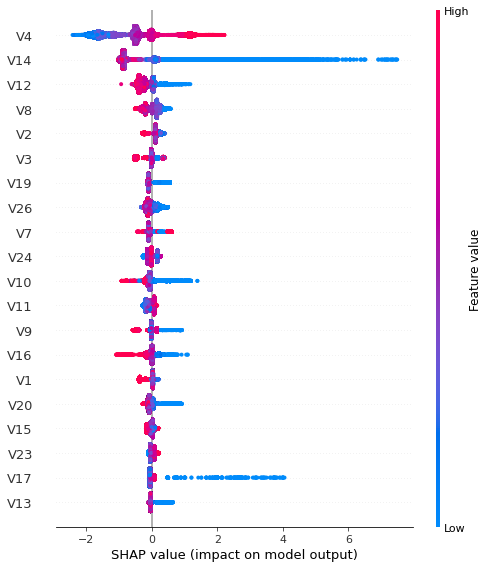

In [151]:
# Summary plot
shap.initjs()
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

## **Dependence Plot using Shapley values**

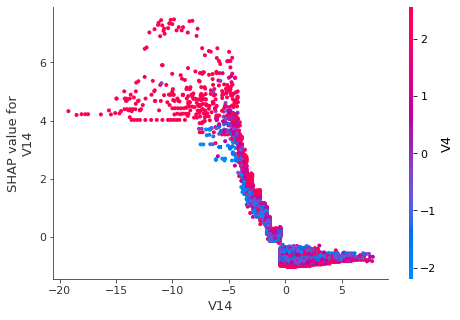

In [161]:
shap.initjs()
shap_values = explainer.shap_values(X_train)
#shap.dependence_plot(13, shap_values, X_train)
shap.dependence_plot('V14', shap_values, X_train)

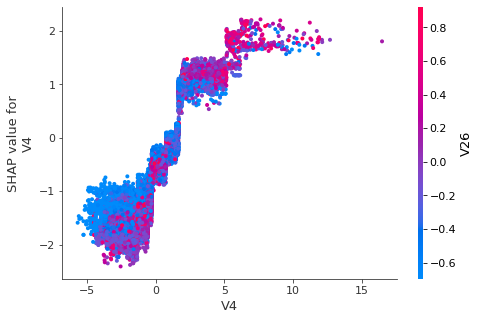

In [168]:
shap.initjs()
shap_values = explainer.shap_values(X_train)
#shap.dependence_plot(13, shap_values, X_train)
shap.dependence_plot('V4', shap_values, X_train)

## **Variable Importance Plot using Shapley values**

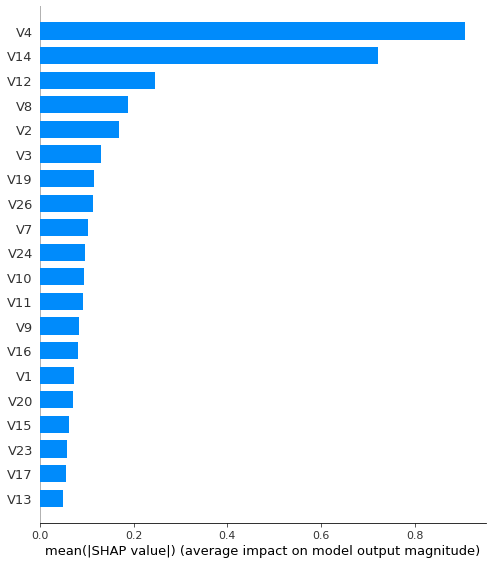

In [169]:
shap.initjs()
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar', color_bar_label='Feature value')

In [187]:
feature_order = np.argsort(-1*np.sum(np.abs(shap_values), axis=0))

In [191]:
features = X_train.columns
features[feature_order]

Index(['V4', 'V14', 'V12', 'V8', 'V2', 'V3', 'V19', 'V26', 'V7', 'V24', 'V10',
       'V11', 'V9', 'V16', 'V1', 'V20', 'V15', 'V23', 'V17', 'V13', 'V21',
       'V28', 'V6', 'V27', 'V22', 'V18', 'V5', 'V25'],
      dtype='object')

Index(['V4', 'V14', 'V12', 'V8', 'V2', 'V3', 'V19', 'V26', 'V7', 'V24', 'V10',
       'V11', 'V9', 'V16', 'V1', 'V20', 'V15', 'V23', 'V17', 'V13', 'V21',
       'V28', 'V6', 'V27', 'V22', 'V18', 'V5', 'V25'],
      dtype='object')

In [185]:
features[np.argsort(-1*np.sum(np.abs(shap_values), axis=0))]

Index(['V4', 'V14', 'V12', 'V8', 'V2', 'V3', 'V19', 'V26', 'V7', 'V24', 'V10',
       'V11', 'V9', 'V16', 'V1', 'V20', 'V15', 'V23', 'V17', 'V13', 'V21',
       'V28', 'V6', 'V27', 'V22', 'V18', 'V5', 'V25'],
      dtype='object')

In [196]:
Values = np.mean(np.abs(shap_values), axis=0)[feature_order]

In [210]:
#shap_importance = pd.DataFrame('Variable Importance': Values, 'Variable': features[feature_order])
shap_importance = pd.DataFrame({'Variable':features[feature_order], 'Variable Importance':Values })

In [214]:
shap_importance['Variable Importance Relative'] =  shap_importance['Variable Importance']/shap_importance['Variable Importance'][0]*100

In [215]:
shap_importance

,Variable,Variable Importance,Variable Importance Relative
0,V4,0.907346,100.000000
1,V14,0.720798,79.440292
2,V12,0.244938,26.995003
3,V8,0.188379,20.761520
4,V2,0.169743,18.707668
5,V3,0.129798,14.305194
6,V19,0.116600,12.850664
7,V26,0.114520,12.621418
8,V7,0.103198,11.373633
9,V24,0.095584,10.534454
